In [16]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pymc as pm
import arviz as az
import multiprocessing as mp
from estival.wrappers import pymc as epm
from estival.sampling import tools as esamp
from estival.wrappers import nevergrad as eng
import estival.priors as esp
from estival.utils.parallel import map_parallel
from estival.utils.sample import SampleTypes
import nevergrad as ng
import pandas as pd
from estival.model import BayesianCompartmentalModel
from tbdynamics.model import build_model
from tbdynamics.constants import (
    age_strata,
    compartments,
    latent_compartments,
    infectious_compartments
)
from tbdynamics.inputs import load_params, load_targets, matrix
from tbdynamics.calib_utils import get_targets
from tbdynamics.utils import round_sigfig


In [12]:
fixed_params = load_params()
model = build_model(
        compartments,
        latent_compartments,
        infectious_compartments,
        age_strata,
        fixed_params,
        matrix,
    )

In [18]:
params = {
    "start_population_size": 2000000.000000584,
    # "contact_rate": 0.00799998496434649,
    "rr_infection_latent": 0.4685598987988698,
    "rr_infection_recovered": 0.20745664581278986,
    "progression_multiplier": 1.6720167708499327,
    "seed_time": 1814.8853385094426,
    "seed_num": 50.64888812259932,
    "seed_duration": 10.491361094180998,
    "smear_positive_death_rate": 0.38654199531405087,
    "smear_negative_death_rate": 0.025755845817440722,
    "smear_positive_self_recovery": 0.23321635702709886,
    "smear_negative_self_recovery": 0.1421912984237043,
    "screening_scaleup_shape": 0.05000000000000329,
    "screening_inflection_time": 2003.1965223765128,
    "screening_end_asymp": 0.550000000000232,
    "detection_reduction": 0.7594960084213216,
}
priors = [
        # esp.UniformPrior("start_population_size", (2000000.0, 2500000.0)),
        esp.UniformPrior("contact_rate", (0.005, 0.010)),
        # esp.UniformPrior("rr_infection_latent", (0.2, 0.5)),
        # esp.UniformPrior("rr_infection_recovered", (0.2, 0.5)),
        # esp.UniformPrior("progression_multiplier", (1.5, 2.0)),
        # esp.UniformPrior("seed_time", (1800.0, 1840.0)),
        # esp.UniformPrior("seed_num", (1.0, 100.00)),
        # esp.UniformPrior("seed_duration", (1.0, 20.0)),
        # esp.UniformPrior("smear_positive_death_rate", (0.335, 0.449)),
        # esp.UniformPrior("smear_negative_death_rate", (0.017, 0.035)),
        # esp.UniformPrior("smear_positive_self_recovery", (0.177, 0.288)),
        # esp.UniformPrior("smear_negative_self_recovery", (0.073, 0.209)),
        # esp.UniformPrior("screening_scaleup_shape", (0.05, 0.15)),
        # esp.UniformPrior("screening_inflection_time", (1990, 2010)),
        # esp.UniformPrior("screening_end_asymp", (0.55, 0.7)),
        # esp.UniformPrior("detection_reduction", (0.7, 0.9)),
    ]

targets = get_targets()

In [19]:
bcm = BayesianCompartmentalModel(model, params, priors, targets)

In [20]:
with pm.Model() as pmc_model:
    start_params = {k: np.clip(v, *bcm.priors[k].bounds(0.99)) for k, v in params.items() if k in bcm.priors}
    variables = epm.use_model(bcm)
    map_params = pm.find_MAP(start=start_params, vars=variables, include_transformed=False, maxeval=500)
    map_params = {k: float(v) for k, v in map_params.items()}
print('Best candidate parameters found:')
for i_param, param in enumerate([p for p in map_params if '_dispersion' not in p]):
    print(f'   {param}: {round_sigfig(map_params[param], 4)} (within bound {priors[i_param].bounds()}')
print(map_params)
params.update(map_params)
model.run(parameters=params)

Output()

Best candidate parameters found:
   contact_rate: 0.008003 (within bound (0.005, 0.01)
{'contact_rate': 0.008002758090207309}


In [23]:
def optimize_ng_with_idx(item):
    idx, sample = item
    opt = eng.optimize_model(
        bcm,
        budget=100,
        opt_class=ng.optimizers.TwoPointsDE,
        suggested=sample,
        num_workers=4,
    )
    rec = opt.minimize(100)
    return idx, rec.value[1]


lhs_samples = bcm.sample.lhs(4, ci=0.67)
lhs_lle = esamp.likelihood_extras_for_samples(lhs_samples, bcm)
lhs_sorted = lhs_lle.sort_values("loglikelihood", ascending=False)
opt_samples_idx = map_parallel(optimize_ng_with_idx, lhs_sorted.iterrows())
best_opt_samps = bcm.sample.convert(opt_samples_idx)
init_samps = best_opt_samps.convert(SampleTypes.LIST_OF_DICTS)[0:4]
n_chains = 4
n_samples = 200
with pm.Model() as pm_model:
    variables = epm.use_model(bcm)
    idata_raw = pm.sample(
        step=[pm.DEMetropolisZ(variables)],
        draws=4000,
        tune=1000,
        cores=4,
        discard_tuned_samples=False,
        chains=n_chains,
        progressbar=True,
        initvals=init_samps,
    )

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 426 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
idata = idata_raw.sel(draw=np.s_[1000:])

array([[<AxesSubplot: title={'center': 'contact_rate'}>,
        <AxesSubplot: title={'center': 'contact_rate'}>]], dtype=object)

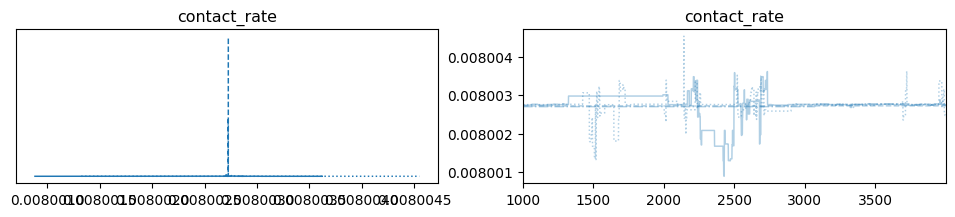

In [25]:
az.plot_trace(idata)